# [과제] 신용카드 데이터 이상치 검출: `IsolationForest` vs `AutoEncoder`

---

 두 모델 모두 안정화되지 않는 게 마음에 들지는 않는다. 어쨌든 그래도 결과 해석 측면에서 공통적으로 발견할 수 있는 측면은 있다.
 
 - AutoEncoder 거리 결과와 Original Label이 많이 일치하지는 않는 듯하다.
 - IsolationForest 돌릴 때마다 결과 달라지긴 하나, AutoEncoder 거리 기준 라벨 셌을 때, 상위 600개 정도 확인하면 거진 비슷하게 잡아 내기는 한다.

---


> AutoEncoder

- 학습 횟수 500, 배치 사이즈 500 일괄 적용.
- early stopping patience 5.
- 파라미터 늘리면 : 과적합 가능성이 있다.
- 돌릴 때마다 달라져서 dropout 적용해 보자.

> IsolationForest

- 이 친구도 만만치 않게 돌릴 때 마다 달라진다.



In [69]:
# module import
import pandas as pd
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.ensemble import IsolationForest
from sklearn.metrics.pairwise import cosine_distances

In [70]:
# 경로 설정
root_path = "/content/drive/My Drive/멀티캠퍼스/[혁신성장] 인공지능 자연어처리 기반/[강의]/조성현 강사님"
data_path = f"{root_path}/dataset"

In [71]:
# 데이터 로드
credit = pd.read_csv(f"{data_path}/creditcard_fraud.csv")

In [72]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [73]:
credit.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [74]:
# 피쳐 선택: Time 제외 모두 사용
X_data = credit.iloc[:, 1:-1]
y_train = credit.iloc[:, -1]

# 표준화
scaler = StandardScaler()
scaler.fit(X_data)
X_train = scaler.transform(X_data)
X_train

array([[-0.69424232, -0.04407492,  1.6727735 , ...,  0.33089162,
        -0.06378115,  0.24496426],
       [ 0.60849633,  0.16117592,  0.1097971 , ..., -0.02225568,
         0.04460752, -0.34247454],
       [-0.69350046, -0.81157783,  1.16946849, ..., -0.13713686,
        -0.18102083,  1.16068593],
       ...,
       [ 0.98002374, -0.18243372, -2.14320514, ...,  0.01103672,
        -0.0804672 , -0.0818393 ],
       [-0.12275539,  0.32125034,  0.46332013, ...,  0.26960398,
         0.31668678, -0.31324853],
       [-0.27233093, -0.11489898,  0.46386564, ..., -0.00598394,
         0.04134998,  0.51435531]])

In [75]:
print(X_train)
print(y_train)

[[-0.69424232 -0.04407492  1.6727735  ...  0.33089162 -0.06378115
   0.24496426]
 [ 0.60849633  0.16117592  0.1097971  ... -0.02225568  0.04460752
  -0.34247454]
 [-0.69350046 -0.81157783  1.16946849 ... -0.13713686 -0.18102083
   1.16068593]
 ...
 [ 0.98002374 -0.18243372 -2.14320514 ...  0.01103672 -0.0804672
  -0.0818393 ]
 [-0.12275539  0.32125034  0.46332013 ...  0.26960398  0.31668678
  -0.31324853]
 [-0.27233093 -0.11489898  0.46386564 ... -0.00598394  0.04134998
   0.51435531]]
0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64


## _1_. AutoEncoder



In [76]:
X_train_AE = X_train.copy()

In [77]:
# 파라미터 설정
n_input = X_train_AE.shape[1]
n_output = n_input

### 모델 파라미터 기록
- 첫 번째 시도: 2층, 14 -> 7, 출력층 sigmoid로 설정, loss 함수 binary crossentropy, adam 0.01 ==> loss 실화니?
- 두 번째 시도: 2층, 14 -> 7, 출력층 linear, loss mse, adam 0.001 ==> loss 좀 사람같구만.
- 세 번째 시도: 2층, 256 -> 512, 출력층 linear, loss mse, adam 0.001 ==> 파라미터 확 늘렸더니 loss값이 확 떨어진다! ==> 그런데 loss trajectory가 울퉁불퉁.
- 네 번째 시도: 돌릴 때마다 결과가 다르게 나와서 dropout 적용. ==> loss 떨어지는 속도는 느리다.
- 다섯 번째 시도: 네 번째 시도랑 결과 비슷하게 나오나 확인만 해 본다.

In [78]:
# 모델 레이어 설정
x_Input = Input(batch_shape=(None, n_input))
x_Encoder1 = Dense(256, activation='relu')(x_Input)
x_Encoder1 = Dropout(0.3)(x_Encoder1)
x_Encoder2 = Dense(512, activation='relu')(x_Encoder1)
x_Encoder2 = Dropout(0.2)(x_Encoder2)
y_Decoder1 = Dense(256, activation='relu')(x_Encoder2)
y_Decoder1 = Dropout(0.3)(y_Decoder1)
y_Decoder2 = Dense(n_output, activation='linear')(y_Decoder1)

# 모델 구조 설정
model = Model(x_Input, y_Decoder2)
model.compile(loss='mse', optimizer=Adam(lr=0.001))
print("====== 모델 전체 구조 ======")
print(model.summary())

====== 모델 전체 구조 ======
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               7680      
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_11 (Dropout)         (None, 

In [79]:
# # 모델 레이어 설정
# x_Input = Input(batch_shape=(None, n_input))
# x_Encoder1 = Dense(256, activation='relu')(x_Input)
# x_Encoder2 = Dense(512, activation='relu')(x_Encoder1)
# y_Decoder1 = Dense(256, activation='relu')(x_Encoder2)
# y_Decoder2 = Dense(n_output, activation='linear')(y_Decoder1)

# # 모델 구조 설정
# model = Model(x_Input, y_Decoder2)
# model.compile(loss='mse', optimizer=Adam(lr=0.001))
# print("====== 모델 전체 구조 ======")
# print(model.summary())

In [11]:
# # 모델 레이어 설정
# x_Input = Input(batch_shape=(None, n_input))
# x_Encoder1 = Dense(14, activation='relu')(x_Input)
# x_Encoder2 = Dense(7, activation='relu')(x_Encoder1)
# y_Decoder1 = Dense(14, activation='relu')(x_Encoder2)
# y_Decoder2 = Dense(n_output, activation='linear')(y_Decoder1)

# # 모델 구조 설정
# model = Model(x_Input, y_Decoder2)
# model.compile(loss='mse', optimizer=Adam(lr=0.001))
# print("====== 모델 전체 구조 ======")
# print(model.summary())

In [80]:
# 모델 학습 파라미터, 체크포인트
EPOCHS = int(input('학습 횟수 설정: '))
BATCH = int(input('배치 사이즈 설정: '))
es = EarlyStopping(monitor='loss', patience=5, verbose=1)

# 훈련
hist5 = model.fit(X_train_AE, X_train_AE,
                  epochs=EPOCHS,
                  batch_size=BATCH,
                  callbacks=[es],
                  shuffle=True)

학습 횟수 설정: 500
배치 사이즈 설정: 500
Epoch 1/500
570/570 [==============================] - 1s 3ms/step - loss: 0.2428
Epoch 2/500
570/570 [==============================] - 1s 3ms/step - loss: 0.1627
Epoch 3/500
570/570 [==============================] - 1s 2ms/step - loss: 0.1496
Epoch 4/500
570/570 [==============================] - 1s 2ms/step - loss: 0.1405
Epoch 5/500
570/570 [==============================] - 1s 2ms/step - loss: 0.1358
Epoch 6/500
570/570 [==============================] - 1s 2ms/step - loss: 0.1321
Epoch 7/500
570/570 [==============================] - 1s 2ms/step - loss: 0.1268
Epoch 8/500
570/570 [==============================] - 1s 3ms/step - loss: 0.1225
Epoch 9/500
570/570 [==============================] - 1s 2ms/step - loss: 0.1224
Epoch 10/500
570/570 [==============================] - 1s 2ms/step - loss: 0.1211
Epoch 11/500
570/570 [==============================] - 1s 2ms/step - loss: 0.1184
Epoch 12/500
570/570 [==============================] - 1s 3ms/step

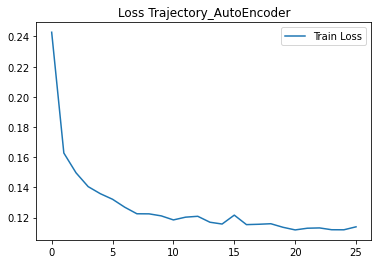

In [81]:
# plot loss: 무엇?
plt.plot(hist5.history['loss'], label='Train Loss')
plt.title('Loss Trajectory_AutoEncoder')
plt.legend()
plt.show()

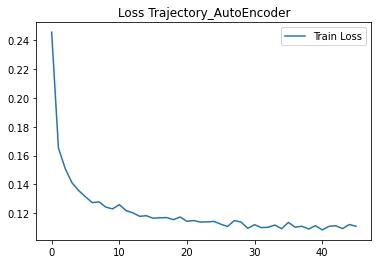

In [39]:
# # plot loss
# plt.plot(hist4.history['loss'], label='Train Loss')
# plt.title('Loss Trajectory_AutoEncoder')
# plt.legend()
# plt.show()

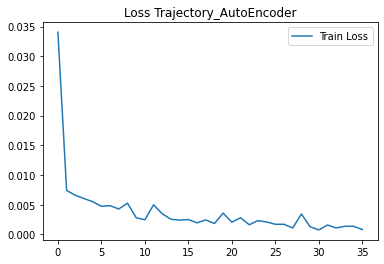

In [ ]:
# # plot loss
# plt.plot(hist3.history['loss'], label='Train Loss')
# plt.title('Loss Trajectory_AutoEncoder')
# plt.legend()
# plt.show()

In [82]:
# 예측
y_pred_AE = model.predict(X_train_AE)
y_pred_AE

array([[-0.48771295,  0.06474841,  1.6377696 , ...,  0.33788997,
        -0.08483705,  0.07098454],
       [ 0.5649479 ,  0.16726285,  0.08006932, ...,  0.01319863,
         0.0610078 , -0.29898164],
       [-0.4946575 , -0.60389006,  1.0506216 , ...,  0.10233732,
         0.03432302,  0.9322188 ],
       ...,
       [ 1.0227733 , -0.04597762, -2.044484  , ...,  0.0522331 ,
        -0.02693545, -0.26910126],
       [-0.1073139 ,  0.32158506,  0.511191  , ...,  0.31686977,
         0.36395872, -0.20762119],
       [-0.18719658,  0.01530151,  0.37736553, ...,  0.1249018 ,
         0.1317167 ,  0.4012785 ]], dtype=float32)

In [83]:
# 거리 계산
def calc_distance(origin, pred):
    dist = []
    for i in range(len(pred)):
        dist.append(np.sqrt(np.sum((np.square(origin[i]-pred[i])))))
    dist = np.array(dist)
    return pd.Series(dist)

In [84]:
%%time
distance_AE = calc_distance(X_train_AE, y_pred_AE)

CPU times: user 2.69 s, sys: 15.7 ms, total: 2.71 s
Wall time: 2.68 s


In [85]:
# # 원래 데이터에 넣기
credit['distance_AE'] = distance_AE
display(credit)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,distance_AE
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.530075
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.273847
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.249000
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.693500
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.632448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1.929082
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,0.805783
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,0.468196
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,0.984857


## _2_. Isolation Forest

In [86]:
# 데이터 준비 
X_train_IF = X_train.copy()
y_train_IF = y_train.copy()
print(X_train_IF)
print(y_train_IF)

[[-0.69424232 -0.04407492  1.6727735  ...  0.33089162 -0.06378115
   0.24496426]
 [ 0.60849633  0.16117592  0.1097971  ... -0.02225568  0.04460752
  -0.34247454]
 [-0.69350046 -0.81157783  1.16946849 ... -0.13713686 -0.18102083
   1.16068593]
 ...
 [ 0.98002374 -0.18243372 -2.14320514 ...  0.01103672 -0.0804672
  -0.0818393 ]
 [-0.12275539  0.32125034  0.46332013 ...  0.26960398  0.31668678
  -0.31324853]
 [-0.27233093 -0.11489898  0.46386564 ... -0.00598394  0.04134998
   0.51435531]]
0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64


In [87]:
# iForest 학습
model = IsolationForest(n_estimators=200, verbose=1)
model.fit(X_train_IF)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.8s finished


IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=200,
                n_jobs=None, random_state=None, verbose=1, warm_start=False)

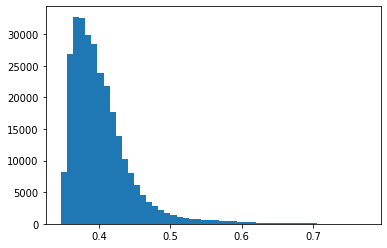

[0 0 0 ... 0 0 0]


In [88]:
# 이상치 점수 by 거리
score = abs(model.score_samples(X_train_IF))

# 이상치 점수 시각화
plt.hist(score, bins=50)
plt.show()

# 이상치 점수 기준: 0.7
y_pred_IF = (score > 0.7).astype(int)
print(y_pred_IF)

In [89]:
# 원래 데이터에 넣기
credit['Class_iForest'] = pd.Series(y_pred_IF)
display(credit)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,distance_AE,Class_iForest
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.530075,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.273847,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1.249000,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.693500,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.632448,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1.929082,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,0.805783,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,0.468196,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,0.984857,0


## _3_. 결과 비교

In [90]:
df = credit.sort_values(by='distance_AE', ascending=False)
display(df)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,distance_AE,Class_iForest
274771,166198.0,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.347360,-3.872425,-12.005487,6.853897,-9.189418,7.126883,-6.795942,8.877742,17.315112,-7.173805,-1.968044,5.501747,-54.497720,-21.620120,5.712303,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0,45.185765,1
58465,48401.0,-36.802320,-63.344698,-20.645794,16.715537,-20.672064,7.694002,24.956587,-4.730111,-2.687312,-8.423404,1.186360,1.879982,3.496723,4.082503,1.406178,0.773133,0.902964,5.041069,-7.213527,39.420904,11.455313,-10.933144,-17.173665,1.180700,-7.025783,-2.534330,-3.602479,3.450224,19656.53,0,31.509488,1
151296,95286.0,-34.549296,-60.464618,-21.340854,16.875344,-19.229075,6.335259,24.422716,-4.964566,0.188912,-8.908182,-0.083514,-2.281866,3.739366,5.989210,2.582162,3.032874,0.530779,4.712398,-6.938297,38.117209,11.502580,-9.499423,-16.513186,0.744341,-7.081325,-2.604551,-3.550963,3.250802,18910.00,0,30.608250,1
23128,32605.0,-23.383129,-18.098804,-20.195367,4.249104,-42.147898,22.529298,36.677268,-4.862800,1.645619,-7.761890,-0.051013,-0.023820,3.027414,-0.504989,2.032532,6.098529,-0.205514,-1.031321,0.220769,-13.694584,-5.893230,-0.139751,-6.086173,1.924973,0.669689,0.449781,11.135740,-9.617915,7429.15,0,30.228448,0
65423,51575.0,-14.904340,12.793880,-7.888739,0.512373,-7.661829,16.614054,-31.764946,-73.216718,-6.290730,-14.741096,-3.038237,7.848392,-5.791881,10.526766,-4.097947,5.477283,3.049153,1.542720,-4.289382,16.756448,-34.830382,10.503090,4.245073,-1.412813,-0.730374,0.133557,-0.394370,0.942177,500.00,0,29.195652,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62153,50156.0,1.131586,0.193790,0.398163,1.401421,-0.113148,-0.160193,0.130063,-0.052137,0.202200,-0.149607,-0.438635,0.834644,0.444163,-0.044166,-0.154546,-0.747685,0.231416,-1.044838,-0.377128,-0.118154,-0.084695,-0.018714,-0.084157,0.111425,0.676194,-0.316583,0.040331,0.020299,25.79,0,0.179989,0
107853,70649.0,1.185415,-0.229779,0.510670,0.594051,-0.806729,-0.686072,-0.183104,-0.070193,0.857675,-0.288238,-0.912143,-0.013898,-1.003550,-0.008549,-0.232036,-0.343242,0.188718,-0.490438,0.319329,-0.112156,-0.091568,-0.122611,-0.093684,0.444856,0.497075,0.671415,-0.044991,0.009806,35.00,0,0.179395,0
277530,167697.0,2.040692,-0.097541,-1.337708,0.390660,-0.116404,-1.384706,0.237230,-0.375085,0.691725,0.026551,-0.796449,-0.041091,-0.577070,0.620165,0.812612,-0.186862,-0.462364,0.014498,-0.236077,-0.253427,0.248362,0.815956,-0.005967,0.066886,0.239145,-0.110813,-0.026941,-0.057029,18.25,0,0.178259,0
16300,27693.0,1.129024,0.184649,0.395273,1.403146,-0.120579,-0.161364,0.127113,-0.048561,0.212479,-0.148189,-0.450365,0.798056,0.375498,-0.030160,-0.146824,-0.744282,0.235392,-1.036118,-0.377078,-0.119921,-0.084699,-0.025043,-0.084476,0.109605,0.673385,-0.316490,0.039635,0.020377,27.09,0,0.176989,0


In [51]:
# # 네 번째 시도: 원래 몇 개 있는지 확인
# print(df['Class'].value_counts()) # original label 이상치 : 492
# print(df['Class_iForest'].value_counts()) # iForest label 이상치 : 207

0    284315
1       492
Name: Class, dtype: int64
0    284600
1       207
Name: Class_iForest, dtype: int64


In [91]:
# 다섯 번째 시도: 원래 몇 개 있는지 확인
print(df['Class'].value_counts()) # original label 이상치 : 492
print(df['Class_iForest'].value_counts()) # iForest label 이상치 : 207

0    284315
1       492
Name: Class, dtype: int64
0    284695
1       112
Name: Class_iForest, dtype: int64


### 원래 이상치가 492개만 있으니까 600개 정도 선에서 비교

- iForest는 이상치로 나오는 거 거진 잘 잡아내는 듯 한데
- 애초에 iForest가 전체 다 못 잡아 내는데

In [92]:
# AE로 계산한 거리 상위 n개 중 이상치 몇 개 있는지 반환
def count_abnormal(data, threshold, num=30):
    for i in range(threshold//num):
        print(f"<< 상위 {(i+1)*num}개에서 이상치 체크 >> ")
        print("  ====== AutoEncoder vs. Original Label ======")
        print(data['Class'][:(i+1)*num].value_counts())        
        print("  ====== AutoEncoder vs. iForest Label ======")
        print(data['Class_iForest'][:(i+1)*num].value_counts())
        print(" ")

In [93]:
# 다섯 번째 시도 결과
count_abnormal(df, 600)

<< 상위 30개에서 이상치 체크 >> 
  ====== AutoEncoder vs. Original Label ======
0    29
1     1
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label ======
1    23
0     7
Name: Class_iForest, dtype: int64
 
<< 상위 60개에서 이상치 체크 >> 
  ====== AutoEncoder vs. Original Label ======
0    57
1     3
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label ======
1    33
0    27
Name: Class_iForest, dtype: int64
 
<< 상위 90개에서 이상치 체크 >> 
  ====== AutoEncoder vs. Original Label ======
0    87
1     3
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label ======
0    51
1    39
Name: Class_iForest, dtype: int64
 
<< 상위 120개에서 이상치 체크 >> 
  ====== AutoEncoder vs. Original Label ======
0    116
1      4
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label ======
0    71
1    49
Name: Class_iForest, dtype: int64
 
<< 상위 150개에서 이상치 체크 >> 
  ====== AutoEncoder vs. Original Label ======
0    140
1     10
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label ===

In [53]:
# # 네 번째 시도
# count_abnormal(df, 600)

<< 상위 30개에서 이상치 체크 >> 
  ====== AutoEncoder vs. Original Label ======
0    26
1     4
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label ======
1    28
0     2
Name: Class_iForest, dtype: int64
 
<< 상위 60개에서 이상치 체크 >> 
  ====== AutoEncoder vs. Original Label ======
0    49
1    11
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label ======
1    53
0     7
Name: Class_iForest, dtype: int64
 
<< 상위 90개에서 이상치 체크 >> 
  ====== AutoEncoder vs. Original Label ======
0    79
1    11
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label ======
1    71
0    19
Name: Class_iForest, dtype: int64
 
<< 상위 120개에서 이상치 체크 >> 
  ====== AutoEncoder vs. Original Label ======
0    102
1     18
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label ======
1    93
0    27
Name: Class_iForest, dtype: int64
 
<< 상위 150개에서 이상치 체크 >> 
  ====== AutoEncoder vs. Original Label ======
0    126
1     24
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label ===

In [24]:
# 세 번째 시도 결과: 달라 진다 계속
# count_abnormal(df, 600)

상위 30개에서 이상치 체크
  ====== AutoEncoder vs. Original Label
0    30
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label
1    20
0    10
Name: Class_iForest, dtype: int64
 
상위 60개에서 이상치 체크
  ====== AutoEncoder vs. Original Label
0    60
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label
1    33
0    27
Name: Class_iForest, dtype: int64
 
상위 90개에서 이상치 체크
  ====== AutoEncoder vs. Original Label
0    90
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label
0    47
1    43
Name: Class_iForest, dtype: int64
 
상위 120개에서 이상치 체크
  ====== AutoEncoder vs. Original Label
0    120
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label
0    64
1    56
Name: Class_iForest, dtype: int64
 
상위 150개에서 이상치 체크
  ====== AutoEncoder vs. Original Label
0    150
Name: Class, dtype: int64
  ====== AutoEncoder vs. iForest Label
0    87
1    63
Name: Class_iForest, dtype: int64
 
상위 180개에서 이상치 체크
  ====== AutoEncoder vs. Original Label
0    180
Name: Class, dtype: int64

## _4_. 기타

### _4.1._ 코사인 거리로 계산

# << 연습 >>

In [ ]:
# 거리 테스트
for i in range(len(X_pred)):
    print(X_pred[i], type(X_pred[i]), X_pred[i].shape)
    print(X_train[i], type(X_train[i]), X_train[i].shape)
    print(X_train[i]-X_pred[i])
    print(np.square(X_train[i]-X_pred[i]))
    print(np.sum(np.square(X_train[i]-X_pred[i])))
    print(np.sqrt(np.sum((np.square(X_train[i]-X_pred[i])))))
    break